# Generation for NLP Baseline Code

```
python3.10 -m venv --system-site-packages /data/ephemeral/home/py310
source /data/ephemeral/home/py310/bin/activate
pip install --upgrade pip
```
위에 커맨드를 사용하여 가상환경을 만들고 IDE의 커널을 생성한 가상환경으로 변경해주세요.

## Install Packages

In [ ]:
# !pip install --no-cache-dir torch==2.9.1+cu128 --index-url https://download.pytorch.org/whl/cu128
# !pip install --no-cache-dir -r requirements.txt

## Import Necessary Libraries

In [1]:
import torch
import transformers
from ast import literal_eval
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM, SFTConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import Dataset
import json
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import evaluate
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from peft import AutoPeftModelForCausalLM, LoraConfig

pd.set_option('display.max_columns', 1000)

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'Could not load this library: /opt/conda/lib/python3.10/site-packages/torchvision/image.so'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# 난수 고정
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

set_seed(42) # magic number :)

## EDA

### Load Data

In [3]:
# Load the train dataset
# TODO Train Data 경로 입력
dataset = pd.read_csv('/data/ephemeral/pro-nlp-generationfornlp-nlp-13/data/train.csv') 

# Flatten the JSON dataset
records = []
for _, row in dataset.iterrows():
    problems = literal_eval(row['problems'])
    record = {
        'id': row['id'],
        'paragraph': row['paragraph'],
        'question': problems['question'],
        'choices': problems['choices'],
        'answer': problems.get('answer', None),
        "question_plus": problems.get('question_plus', None),
    }
    # Include 'question_plus' if it exists
    if 'question_plus' in problems:
        record['question_plus'] = problems['question_plus']
    records.append(record)
        
# Convert to DataFrame
df = pd.DataFrame(records)

### Print missing values

In [4]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
id                  0
paragraph           0
question            0
choices             0
answer              0
question_plus    2031
dtype: int64


In [11]:
# 빈 문자열('')이 아닌, 실제 내용이 있는 데이터만 필터링
real_data = df[df['question_plus'] != '']

print(f"전체 데이터 개수: {len(df)}")
print(f"실제 내용이 있는 question_plus 개수: {len(real_data)}")

if len(real_data) > 0:
    display(real_data[['id', 'question_plus']])
else:
    print("question_plus에 내용이 있는 데이터가 없습니다.")

전체 데이터 개수: 2031
실제 내용이 있는 question_plus 개수: 0
question_plus에 내용이 있는 데이터가 없습니다.


### Basic information about the dataset

In [12]:
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2031 entries, 0 to 2030
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                2031 non-null   object
 1   paragraph         2031 non-null   object
 2   question          2031 non-null   object
 3   choices           2031 non-null   object
 4   answer            2031 non-null   int64 
 5   question_plus     2031 non-null   object
 6   full_question     2031 non-null   object
 7   question_length   2031 non-null   int64 
 8   paragraph_length  2031 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 142.9+ KB


### EDA on 'question' and 'choices'

In [13]:
# Combine 'question' and 'question_plus' if available
df['question_plus'] = df['question_plus'].fillna('')
df['full_question'] = df.apply(lambda x: x['question'] + ' ' + x['question_plus'] if x['question_plus'] else x['question'], axis=1)

# Calculate the length of each question
df['question_length'] = df['full_question'].apply(len)
df['paragraph_length'] = df['paragraph'].apply(len)

### Question Length Distribution

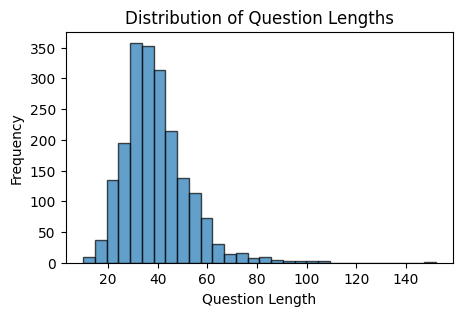

In [14]:
plt.figure(figsize=(5, 3))
plt.hist(df['question_length'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Question Lengths')
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.show()

### Paragraph Length Distribution

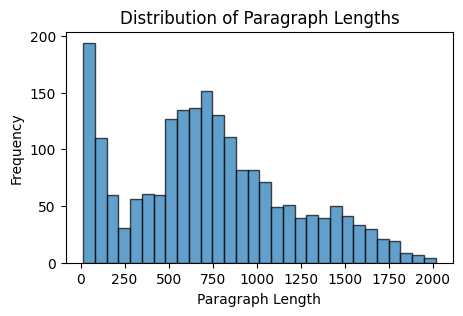

In [8]:
plt.figure(figsize=(5, 3))
plt.hist(df['paragraph_length'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Paragraph Lengths')
plt.xlabel('Paragraph Length')
plt.ylabel('Frequency')
plt.show()

In [15]:
# 지문(paragraph) 길이의 요약 통계량 확인
print(df['paragraph_length'].describe())

count    2031.000000
mean      735.324471
std       462.595621
min        15.000000
25%       407.500000
50%       699.000000
75%      1014.500000
max      2017.000000
Name: paragraph_length, dtype: float64


In [27]:
!pip install seaborn

                  count        mean         std   min     25%    50%     75%  \
question_type                                                                  
독해형 (RC)           84.0  619.261905  531.169342  38.0  180.25  446.0   926.5   
지식형 (Knowledge)  1947.0  740.331793  458.902588  15.0  441.00  705.0  1015.0   

                    max  
question_type            
독해형 (RC)         1729.0  
지식형 (Knowledge)  2017.0  


/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 46021 (\N{HANGUL SYLLABLE DOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


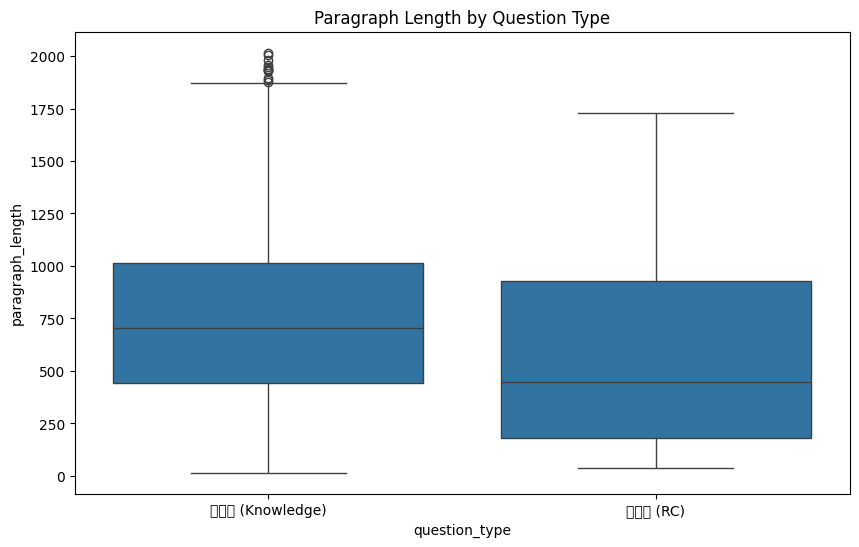

In [28]:
# 분석을 위한 함수 정의
def classify_question_type(question):
    # 지문을 직접 가리키는 키워드 리스트 (독해형 시그널)
    rc_keywords = ['윗글', '다음 글', '일치', '추론', '적절한', '㉠', 'ⓐ', '밑줄', '빈칸']
    
    # 키워드가 포함되어 있으면 '독해형(RC)', 아니면 '지식형(Knowledge)'으로 분류
    for kw in rc_keywords:
        if kw in str(question):
            return '독해형 (RC)'
    return '지식형 (Knowledge)'

# 1. 질문 유형 분류 파생 변수 생성
df['question_type'] = df['question'].apply(classify_question_type)

# 2. 유형별 지문 길이 평균 비교
print(df.groupby('question_type')['paragraph_length'].describe())

# 3. 시각화로 확인 (Boxplot)


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='question_type', y='paragraph_length', data=df)
plt.title('Paragraph Length by Question Type')
plt.show()

=== 선지 개수 분포 ===
num_choices
4     792
5    1239
Name: count, dtype: int64


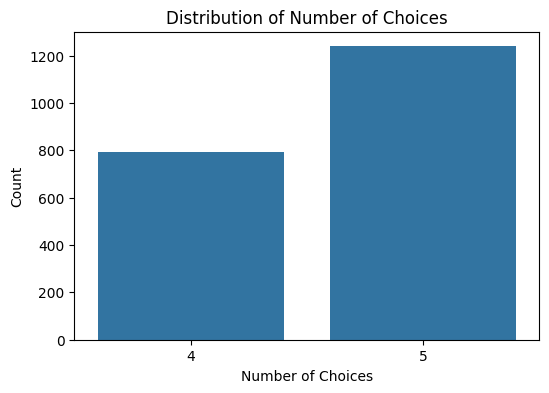

In [29]:
# 1. 선지 개수(num_choices) 계산
# choices 컬럼의 각 리스트의 길이를 젭니다.
df['num_choices'] = df['choices'].apply(len)

# 2. 분포 확인 (4지선다, 5지선다 개수 세기)
print("=== 선지 개수 분포 ===")
print(df['num_choices'].value_counts().sort_index())

# 3. 시각화 (선택 사항)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='num_choices', data=df)
plt.title('Distribution of Number of Choices')
plt.xlabel('Number of Choices')
plt.ylabel('Count')
plt.show()

In [33]:
# 1. 선지 개수 계산 (아직 안 했다면 수행)
if 'num_choices' not in df.columns:
    df['num_choices'] = df['choices'].apply(len)

# 2. 4지선다 문제 10개 추출
df_4_choices = df[df['num_choices'] == 4].head(10)

# 3. 5지선다 문제 10개 추출
df_5_choices = df[df['num_choices'] == 5].head(10)

# 4. 결과 출력 (텍스트가 잘리지 않게 설정)
import pandas as pd
pd.set_option('display.max_colwidth', None)


display(df_4_choices[['paragraph']])
display(df_4_choices[['id', 'question', 'choices', 'answer']])

,paragraph
0,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服) 절차에 대하여 논한 것이 신과는 큰 차이가 있었습니다 . 장자를 위하여 3년을 입는 까닭은 위로 ‘정체(正體)’가 되기 때문이고 또 전 중(傳重: 조상의 제사나 가문의 법통을 전함)하기 때문입니다 . …(중략) … 무엇보다 중요한 것은 할아버지와 아버지의 뒤를 이은 ‘정체’이지, 꼭 첫째이기 때문에 참 최 3년 복을 입는 것은 아닙니다 .”라고 하였다 .－현종실록 －ㄱ.기 사환국으로 정권을 장악하였다 .ㄴ.인 조반정을 주도 하여 집권세력이 되었다 .ㄷ.정조 시기에 탕평 정치의 한 축을 이루었다 .ㄹ.이 이와 성혼의 문인을 중심으로 형성되었다."
1,"(가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사령 박상진을 중심으로 독립군 양성을 목적으로 하였다."
2,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순조로워 우리나라 지맥의 뿌리가 되니 대업을 만대에 전할 땅이다. 왕은 춘하 추동네 계절의 중간달에 그곳에 가 100일 이상 머물러서 나라를 안녕케 하라. － 고려사－
3,"이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다. …(중략) …소정방이 신라군이 늦게 왔다는 이유로 군문에서 신라 독군 김문영의 목을 베고자 하니, 그가 군사들 앞에 나아가 “황산 전투를 보지도 않고 늦게 온 것을 이유로 우리를 죄 주려 하는구나. 죄도 없이 치욕을 당할 수는 없으니, 결단코 먼저 당나라 군사와 결전을 한 후에 백제를 쳐야겠다.”라고 말하였다."
4,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가)이/가 크게 노하여 한성부의 조례(皂隷)와 병졸로 하여 금 한 강 밖으로 몰아내게 하고 드디어 천여 곳의 서원을 철폐하고 그 토지를 몰수하여 관에 속하게 하였다.－대한계년사 －"
5,"(가)의 사신 고제덕 등이 일본에 와서 왕이 보낸 국서를 전하였다. 그 국서에 이르기를 “나(대무 예)는 큰 나라를 맡아 여러 주변국을 다스렸으며, 고구려의 옛 땅을 회복하였고 부여의 풍속을 이었다.”라고 하였다."
6,(가)신라의 한강 유역 확보 (나)관산성 전투(다) 백제의 웅진 천도 (라)고구려의 평양 천도
7,"신돈이 (가)을/를 설치하자고 요청하자, …(중략)…이 제 도감이 설치되었다. …(중략)… 명령이 나가자 권세가 중에 전민을 빼앗은 자들이 그 주인에게 많이 돌려주었으며, 전국에서 기뻐하였다.－고려사－"
8,(가) 황제가 영원히 가시던 길에 엎드려 크게 통곡하던 우리는 …(중략) … 우리민족의 새로운 기백과 책동이 발발하기를 간절히 기대하는 바이다.－동아일보 1926년 6월 12일－
9,"올해 초가을에 비로소 저는 책을 완성하여 그 이름을 성학집요 라고 하였습니다. 이 책에는 임금이 공부해야 할 내용과 방법, 정치하는 방법, 덕을 쌓아 실천하는 방법과 백성을 새롭게 하는 방법이 실려 있습니다. 또한 작은 것을 미루어 큰 것을 알게 하고 이것을 미루어 저것을 밝혔으니, 천하의 이치가 여기에서 벗어나 지 않을 것입니다. 따라서 이것은 저의 글이 아니라 성현의 글이 옵니다."


,id,question,choices,answer
0,generation-for-nlp-425,상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",2
1,generation-for-nlp-426,(가)에 대한 설명으로 옳지 않은 것은?,"[고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 상업활동이 이루어졌다., 정도전은 궁궐 전각(殿閣)과도성성문 등의 이름을 지었다., 성곽은 거중기 등을 이용하여 약 2년 만에 완성되었다.]",1
2,generation-for-nlp-427,(가) 지역에 대한 설명으로 옳은 것은?,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운동을 펼쳤다., 망이 ․망소이가 이곳에서 봉기하였다., 몽골이 이곳에 동녕부를 두었다.]",4
3,generation-for-nlp-428,밑줄 친 ‘그’에 대한 설명으로 옳은 것은?,"[살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., 청해진을 설치하고 해상 무역을 전개하였다 ., 대가야를 정벌하여 낙동강 유역을 확보하였다 .]",2
4,generation-for-nlp-429,(가) 인물이 추진한 정책으로 옳지 않은 것은?,"[사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ., 통상 수교 거부 정책을 추진하였다 .]",3
5,generation-for-nlp-431,(가) 국가에 대한 설명으로 옳은 것은?,"[나 당연합군의 공격으로 멸망하였다 ., 9주 5소경의 지방 행정 구역을 두었다 ., 중앙 행정 기구로 3성 6부를 설치하였다 ., 고구려의 수도였던 평양을 서경으로 삼았다 .]",3
6,generation-for-nlp-432,다음 사건을 시기 순으로 바르게 나열한 것은?,"[(가)→(라)→(나)→(다), (나)→(다)→(가)→(라), (다)→(나)→(가)→(라), (라)→(다)→(가)→(나) ]",4
7,generation-for-nlp-433,(가)에 대한 설명으로 옳은 것은?,"[시 전의 물가를 감독하는 임무를 담당하였다 ., 국가재정의 출납과 회계 업무를 총괄하였다 ., 불법적으로 점유된 토지와 노비를 조사하였다 ., 부족한 녹봉을 보충하고자 관료에게 녹과 전을 지급하였다 .]",3
8,generation-for-nlp-434,(가) 재위 기간에 있었던 사실이 아닌 것은?,"[일본은 동양척식 주식회사를 설립하였다., 일본이 간도를 청에 귀속하는 협약을 체결하였다., 유생의 병장 중심으로 13도 창의군을 결성하였다., 대한제국의 외교권을 박탈하고 통감부를 설치하였다.]",1
9,generation-for-nlp-435,밑줄 친 ‘저’에 대한 설명으로 옳은 것은?,"[예안향약을 만들었다 ., 동호문답 을 저술하였다 ., 백운동 서원을 건립하였다 ., 왕자의 난 때 죽임을 당했다 .]",2


4지선다 데이터 개수: 792개
5지선다 데이터 개수: 1239개
------------------------------
=== 지문 길이(Paragraph Length) 통계 ===

[4지선다형]
count     792.000000
mean      319.986111
std       256.084661
min        15.000000
25%        85.750000
50%       285.500000
75%       500.250000
max      1292.000000
Name: paragraph_length, dtype: float64

[5지선다형]
count    1239.000000
mean     1000.819209
std       357.898774
min       503.000000
25%       711.500000
50%       909.000000
75%      1252.000000
max      2017.000000
Name: paragraph_length, dtype: float64


/tmp/ipykernel_381973/797523370.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='num_choices', y='paragraph_length', data=df, ax=axes[1], palette='Set2')


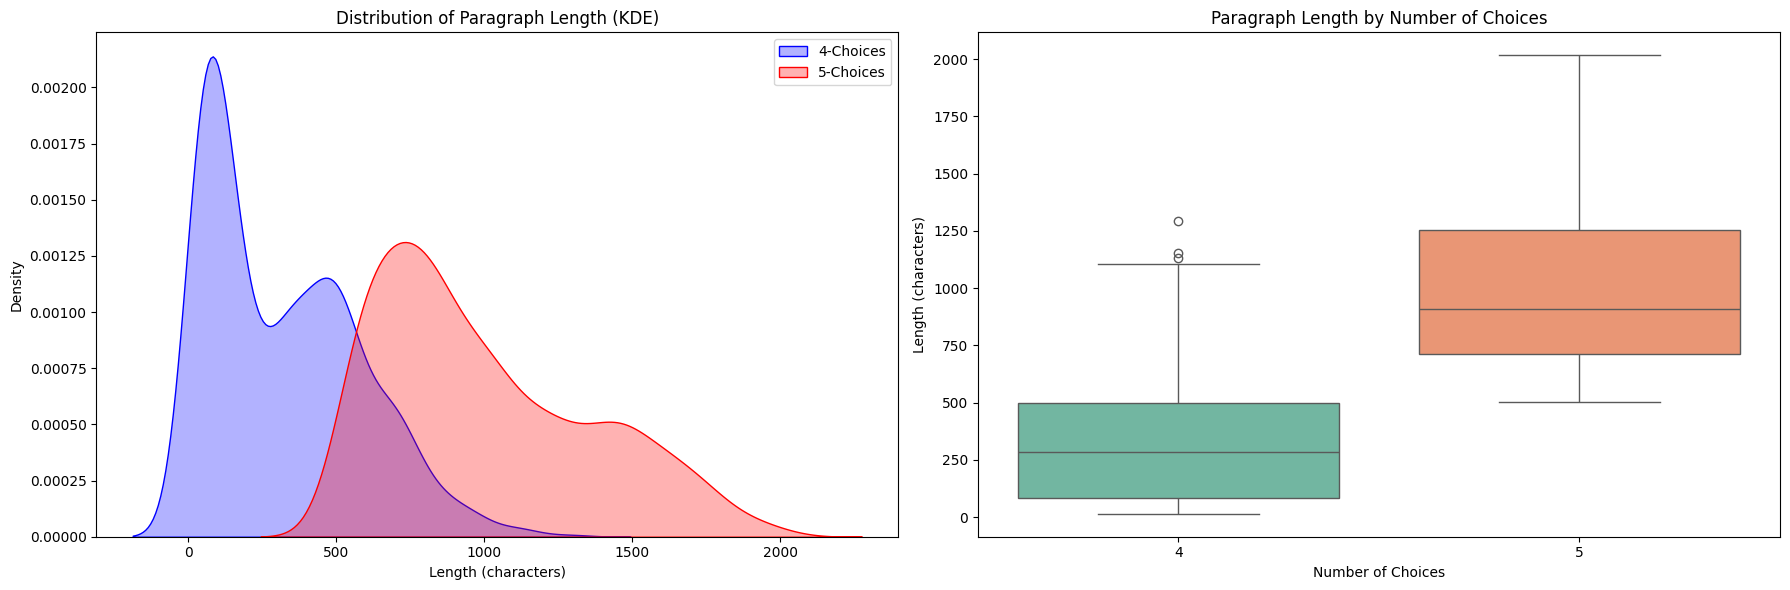

In [35]:
from ast import literal_eval

# 1. 데이터 로드 및 전처리 함수
def load_and_preprocess(filepath):
    df_raw = pd.read_csv(filepath)
    
    records = []
    for _, row in df_raw.iterrows():
        # problems 컬럼 파싱 (문자열 -> 딕셔너리)
        problems = literal_eval(row['problems'])
        
        record = {
            'id': row['id'],
            'paragraph': row['paragraph'],  # 지문
            'question': problems['question'], # 질문
            'choices': problems['choices'],   # 선지 리스트
            'answer': problems.get('answer', None)
        }
        records.append(record)
        
    df = pd.DataFrame(records)
    
    # 파생 변수 생성
    df['paragraph_length'] = df['paragraph'].apply(len)  # 지문 길이
    df['num_choices'] = df['choices'].apply(len)         # 선지 개수 (4 or 5)
    
    return df

# 2. 4지선다 vs 5지선다 데이터 분리
df_4 = df[df['num_choices'] == 4]
df_5 = df[df['num_choices'] == 5]

print(f"4지선다 데이터 개수: {len(df_4)}개")
print(f"5지선다 데이터 개수: {len(df_5)}개")
print("-" * 30)

# 3. 기초 통계량 비교 출력
print("=== 지문 길이(Paragraph Length) 통계 ===")
print("\n[4지선다형]")
print(df_4['paragraph_length'].describe())
print("\n[5지선다형]")
print(df_5['paragraph_length'].describe())

# 4. 시각화 (히스토그램 & 박스플롯)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# (1) 분포 비교 (KDE Plot)
sns.kdeplot(data=df_4['paragraph_length'], label='4-Choices', fill=True, ax=axes[0], color='blue', alpha=0.3)
sns.kdeplot(data=df_5['paragraph_length'], label='5-Choices', fill=True, ax=axes[0], color='red', alpha=0.3)
axes[0].set_title('Distribution of Paragraph Length (KDE)')
axes[0].set_xlabel('Length (characters)')
axes[0].legend()

# (2) 통계적 차이 확인 (Boxplot)
sns.boxplot(x='num_choices', y='paragraph_length', data=df, ax=axes[1], palette='Set2')
axes[1].set_title('Paragraph Length by Number of Choices')
axes[1].set_xlabel('Number of Choices')
axes[1].set_ylabel('Length (characters)')

plt.tight_layout()
plt.show()

# 질문 길이와 본문 길이 상관성 분석

In [ ]:
def plot_scatter_comparison(df):
    """질문 길이 vs paragraph 길이 산점도"""
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # 기본 산점도
    axes[0].scatter(df['question_length'], df['paragraph_length'], 
                   alpha=0.5, s=10)
    axes[0].set_xlabel('Question Length (characters)')
    axes[0].set_ylabel('Paragraph Length (characters)')
    axes[0].set_title('Question Length vs Paragraph Length')
    axes[0].grid(alpha=0.3)
    
    # 상관관계 표시
    correlation = df['question_length'].corr(df['paragraph_length'])
    axes[0].text(0.05, 0.95, f'Correlation: {correlation:.3f}',
                transform=axes[0].transAxes, 
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 밀도 산점도 (hexbin)
    axes[1].hexbin(df['question_length'], df['paragraph_length'], 
                   gridsize=30, cmap='YlOrRd')
    axes[1].set_xlabel('Question Length (characters)')
    axes[1].set_ylabel('Paragraph Length (characters)')
    axes[1].set_title('Density Plot (Hexbin)')
    plt.colorbar(axes[1].collections[0], ax=axes[1], label='Count')
    
    plt.tight_layout()
    plt.savefig('scatter_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_scatter_comparison(df)

## 심층 EDA Frequency of Words in Question

In [ ]:
# !pip install konlpy
# !pip install wordcloud 

In [ ]:
from konlpy.tag import Okt
from collections import Counter

def Q_korean_word_freq(df):
    okt = Okt()
    stopwords = {
        '것', '수', '등', '및', '제', '때', '대한',
        '옳은', '않은', '틀린', '설명', '인가', '무엇',
        '다음', '보기', '문제', '답', '번', '있는' ,'가장',
    }
    # 모든 질문 합치기
    all_text = ' '.join(df['question'].astype(str))
    
    # 형태소 분석 (명사만 추출)
    nouns = okt.nouns(all_text)
    
    # 한 글자 단어 제거
    nouns = [word for word in nouns if len(word) > 1 and word not in stopwords]
    
    # 빈도수 계산
    word_freq = Counter(nouns)
    
    # 상위 30개
    print("=== 상위 30개 명사 ===")
    for word, count in word_freq.most_common(30):
        print(f"{word}: {count}번")
    
    return word_freq

Q_freq = Q_korean_word_freq(df)

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud_from_freq(word_freq, title='단어 빈도 워드클라우드'):
    """Counter 객체로 워드클라우드 생성"""
    
    # 한글 폰트 설정 (환경에 맞게 선택)
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # Linux
    # font_path = 'C:/Windows/Fonts/malgun.ttf'  # Windows
    # font_path = '/System/Library/Fonts/AppleGothic.ttf'  # Mac
    
    # 워드클라우드 생성
    wordcloud = WordCloud(
        font_path=font_path,
        width=1200,
        height=600,
        background_color='white',
        max_words=100,
        relative_scaling=0.3,
        colormap='viridis'
    ).generate_from_frequencies(word_freq)  # ← Counter 객체 직접 사용!
    
    # 시각화
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# 사용
create_wordcloud_from_freq(Q_freq)

## 심층 EDA Frequency of Words in Paragraph

In [ ]:
from konlpy.tag import Okt
from collections import Counter

def P_korean_word_freq(df):
    okt = Okt()
    stopwords = {
        '것', '수', '등', '및', '제', '때', '대한',
        '옳은', '않은', '틀린', '설명', '인가', '무엇',
        '다음', '보기', '문제', '답', '번', '있는' ,'가장',
    }
    # 모든 질문 합치기
    all_text = ' '.join(df['paragraph'].astype(str))
    
    # 형태소 분석 (명사만 추출)
    nouns = okt.nouns(all_text)
    
    # 한 글자 단어 제거
    nouns = [word for word in nouns if len(word) > 1 and word not in stopwords]
    
    # 빈도수 계산
    word_freq = Counter(nouns)
    
    # 상위 30개
    print("=== 상위 30개 명사 ===")
    for word, count in word_freq.most_common(30):
        print(f"{word}: {count}번")
    
    return word_freq

P_freq = P_korean_word_freq(df)

In [ ]:
create_wordcloud_from_freq(P_freq)